# Example: Total Nitrogen Deposition Maps from GEOS-CF

This notebook describes how total nitrogen deposition maps have been constructed from archived GEOS-CF fields. GEOS-CF is documented here: https://gmao.gsfc.nasa.gov/weather_prediction/GEOS-CF/, and here: https://doi.org/10.1029/2020MS002413.

GEOS-CF archives hourly deposition fluxes in the "xgc_tavg_1hr_g1440x721_x1" files for the following species:

*Wet Deposition:*
- Inorganic Nitrates ("NIT")
- Ammonium ("NH4")
- Nitric Acid ("HNO3")
- Ammonia ("NH3")
    
*Dry Deposition:*
- Inorganic Nitrates ("NIT")
- Ammonium ("NH4")
- Ammonia ("NH3")
- Nitric Acid ("HNO3")
- Nitrogen Dioxide ("NO2")

The GEOS-Chem chemistry mechanism includes dry deposition calculations of several other organic nitrogen species (e.g. PAN, isoprene nitrates) that I expect could be included in the GEOS-CF public archive. This also means that the mass balance of currently archived deposition vs. total nitrogen emissions may not be perfectly closed.

Data access and download instructions are included below.

### Import necessary modules

In [1]:
import xarray as xr
import numpy as np
import datetime
import time
from netCDF4 import Dataset, num2date, date2num
import calendar
import glob
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import matplotlib.cm as cm
import matplotlib.colors as colors

### Retrieving the relevant GEOS-CF fields

Below, the OpeNDAP protocol is used to retrieve the hourly nitrogen deposition fields from the archived GEOS-CF output. These fields are saved locally to be analyzed separately.

*Note: The GEOS-CF OpeNDAP server frequently disconnects during downloading. I have programmed a work-around that submits an interactive download script to the BU shared computing cluster, then uses Python to periodically check whether the job disconnects. If/when disconnected, Python automatically resubmits a new ineractive download script to the cluster starting from the last available local file (see "py_shell_test.sh" which relies on "geoscf_deposition_fn"). In any case, the instructions below show exactly how fields can be saved from GEOS-CF.*

In [ ]:
# GEOS-CF URL and File Type
url_dir = "https://opendap.nccs.nasa.gov/dods/gmao/geos-cf/assim/"
url_xgc = "xgc_tavg_1hr_g1440x721_x1"

# Create OpeNDAP URL
url = url_dir + url_xgc

# Directory to store the retrieved output locally
out_directory = '/projectnb/atmchem/geddes/downloads_nb/geos_cf_flux/'

# Name of variables to extract
variables = ['drydepflx_nit',  'drydepflx_hno3', 
             'wetdepflx_hno3', 'drydepflx_nh4',
             'drydepflx_no2',  'drydepflx_nh3',
             'wetdepflx_nh4',  'wetdepflx_nh3',
             'wetdepflx_nit',  'wetdepflx_so2',
             'wetdepflx_so4',  'drydepflx_o3']

# Open GEOS-CF dataset
ds = xr.open_dataset(url)

# Calculate number of time points available (xgc_tavg_1hr output available hourly)
NN = ds.dims['time']

# For each time point (hour), retrieve desired variables and save as local NetCDF file
for i in range(0, NN):
    
    # Set a timer for checking how long it is taking
    start = time.time()
    
    # Point to desired variables at time i
    nc = ds[variables][dict(time=i)]

    # Create an output name
    datestring = np.datetime_as_string(nc.time.values)[0:13]
    filename = out_directory+'depflux-'+datestring+'-N'+str(i).zfill(5)+'.nc'

    # Store desired variables to local file
    nc.to_netcdf(path=filename)
    nc.close()

    # Check timer and print some information to screen.
    elapsed = (time.time() - start)  # time elapsed
    print('---------------------------')
    print(datestring)
    print("Elapsed since last entry: " + str(datetime.timedelta(seconds=elapsed)))

### Calculating Total N Deposition

With local files ready to be analyzed, we can now calculate total deposition by summing the deposition fields over time, and across all relevant N-species. In addition to annual deposition, it may be useful to provide files that store total deposition by month. 

First, create a function to sum deposition fluxes by month. Store wet and dry species' total fluxes in a dictionary.

In [2]:
def total_dep_month(y, m):
    
    # Inputs:
    #  y == year
    #  m == month
    
    # Output:
    #  dep_dict == dictionary containing wet and dry deposition by species 

    # Open an example file to get array dimensions.
    temp_f  = "/projectnb/atmchem/geddes/downloads_nb/geos_cf_flux/depflux-2021-01-01T00-N26304.nc"
    temp = Dataset(temp_f, 'r')

    lat = np.asarray(temp['lat'][:])
    lon = np.asarray(temp['lon'][:])

    # Sample array dimensions
    S = np.shape(temp['drydepflx_nit'])
    temp.close()

    # Create empty array
    drynit_array = np.zeros(S, dtype='float')
    dryhno3_array = np.zeros(S, dtype='float')
    drynh4_array = np.zeros(S, dtype='float')
    dryno2_array = np.zeros(S, dtype='float')
    drynh3_array = np.zeros(S, dtype='float')

    wethno3_array = np.zeros(S, dtype='float')
    wetnh4_array = np.zeros(S, dtype='float')
    wetnh3_array = np.zeros(S, dtype='float')
    wetnit_array = np.zeros(S, dtype='float')

    # Check how many days are in the month.
    d_last = datetime.date(y, m, calendar.monthrange(y, m)[-1]).day

    # Open the file for each day-hour of the month:
    for d in range(1, d_last+1):

        # Print some information to the screen:
        print("Working on:", y, m, d)
        
        for h in range(24):

            # Assemble file name given year-month-day-hour combination.
            files = glob.glob('/projectnb/atmchem/geddes/downloads_nb/geos_cf_flux/depflux-'+str(y)+'-'+str(m).zfill(2)+'-'+str(d).zfill(2)+'T'+str(h).zfill(2)+'-N*')

            # Double check there is one (and only one) file for each day-hour.
            if np.shape(files)[0] == 0:
                print('------ MISSING FILE! ------- at: ', y, m, d, h)
            if np.shape(files)[0] > 1:
                print('------ TOO MANY MATCHES! ------- at: ', y, m, d, h)

            file_name = files[0]

            # Print some information to the screen
            # print(file_name)

            # Point to dataset in the file
            temp = Dataset(file_name, 'r')

            # Grab the deposition flux variable for each species, and sum every hour 
            drynit_array = drynit_array + np.asarray(temp['drydepflx_nit'][:])
            dryhno3_array = dryhno3_array + np.asarray(temp['drydepflx_hno3'][:])
            drynh4_array = drynh4_array + np.asarray(temp['drydepflx_nh4'][:])
            dryno2_array = dryno2_array + np.asarray(temp['drydepflx_no2'][:])
            drynh3_array = drynh3_array + np.asarray(temp['drydepflx_nh3'][:])

            wethno3_array = wethno3_array + np.asarray(temp['wetdepflx_hno3'][:])
            wetnh4_array = wetnh4_array + np.asarray(temp['wetdepflx_nh4'][:])
            wetnh3_array = wetnh3_array + np.asarray(temp['wetdepflx_nh3'][:])
            wetnit_array = wetnit_array + np.asarray(temp['wetdepflx_nit'][:])

            # Close the dataset.
            temp.close()
 

    # Dry deposition: Convert from molec cm-2 s-1 to kg ha-1:
    # (* 3600 s [per hr of output] )
    # (/ 6.023e23 molec/mol)
    # (* 14.01 g N/mol N)
    # (* 1e8 cm2/ha)
    # (/ 1000 g/kg)

    # Conversion factor:
    dry_conv = 3600*(1/6.02e23)*(14.01)*(1e8)*(1/1000)
    
    drynit_array = drynit_array*dry_conv
    dryhno3_array = dryhno3_array*dry_conv
    drynh4_array = drynh4_array*dry_conv
    dryno2_array = dryno2_array*dry_conv
    drynh3_array = drynh3_array*dry_conv
    
    # Wet deposition: Convert from kg m-2 s-1 to kg ha-1
    
    # Then convert to kg N/ha
    # (* 3600 s [per hour of output])
    # (* 14.01 g N/mol N)
    # (* 1000 m2/ha)

    # Conversion factor:
    wet_conv = 3600*(14.01)*1000

    # (Don't forget to scale by molar masses)
    wethno3_array = wethno3_array*wet_conv*(1/63.01)
    wetnh4_array = wetnh4_array*wet_conv*(1/18.04)
    wetnh3_array = wetnh3_array*wet_conv*(1/17.03)
    wetnit_array = wetnit_array*wet_conv*(1/62.)

    deposition_dict = {'Dry_NIT': drynit_array,
                       'Dry_HNO3': dryhno3_array,
                       'Dry_NH4': drynh4_array,
                       'Dry_NO2': dryno2_array,
                       'Dry_NH3': drynh3_array,
                       'Wet_HNO3': wethno3_array,
                       'Wet_NH4': wetnh4_array,
                       'Wet_NH3': wetnh3_array,
                       'Wet_NIT': wetnit_array}
    
    return deposition_dict

Now we can calculate and store the integrated deposition of each species by month.

In [3]:
# Now we can calculate deposition for each species by month:
# E.g., for 2021:
y = 2021

# Set up empty dictionary to contain monthly deposition.
Monthly_Dep = {}

for m in range(1, 13, 1): # Here, only for January (m=1) for demonstration since I'm still downloading files.
    deposition_temp = total_dep_month(y, m)
    Monthly_Dep['Dep_'+str(m).zfill(2)] = deposition_temp

Working on: 2021 1 1
Working on: 2021 1 2
Working on: 2021 1 3
Working on: 2021 1 4
Working on: 2021 1 5
Working on: 2021 1 6
Working on: 2021 1 7
Working on: 2021 1 8
Working on: 2021 1 9
Working on: 2021 1 10
Working on: 2021 1 11
Working on: 2021 1 12
Working on: 2021 1 13
Working on: 2021 1 14
Working on: 2021 1 15
Working on: 2021 1 16
Working on: 2021 1 17
Working on: 2021 1 18
Working on: 2021 1 19
Working on: 2021 1 20
Working on: 2021 1 21
Working on: 2021 1 22
Working on: 2021 1 23
Working on: 2021 1 24
Working on: 2021 1 25
Working on: 2021 1 26
Working on: 2021 1 27
Working on: 2021 1 28
Working on: 2021 1 29
Working on: 2021 1 30
Working on: 2021 1 31
Working on: 2021 2 1
Working on: 2021 2 2
Working on: 2021 2 3
Working on: 2021 2 4
Working on: 2021 2 5
Working on: 2021 2 6
Working on: 2021 2 7
Working on: 2021 2 8
Working on: 2021 2 9
Working on: 2021 2 10
Working on: 2021 2 11
Working on: 2021 2 12
Working on: 2021 2 13
Working on: 2021 2 14
Working on: 2021 2 15
Workin

### Save total deposition to new files

We can now package the monthly (and annual) deposition by species, wet, dry, and total, as desired in convenient formats (e.g., NetCDF?)

In [5]:
# Open an example file to get lat lon values.
temp_f  = "/projectnb/atmchem/geddes/downloads_nb/geos_cf_flux/depflux-2021-01-01T00-N26304.nc"
temp = Dataset(temp_f, 'r')
lat = np.asarray(temp['lat'][:])
lon = np.asarray(temp['lon'][:])
temp.close()

nmonths = 12;
unout = 'days since 2021-01-01 00:00:00'

ny, nx = (np.shape(lat)[0], np.shape(lon)[0])

dataout = np.random.random((nmonths,ny,nx)); # create some random data
datesout = [datetime.datetime(2021,imonth,1) for imonth in range(1, nmonths+1)]; # create datevalues

ncout = Dataset('GEOS-CF-NDEP-2021.nc','w','NETCDF3'); # using netCDF3 for output format 
ncout.createDimension('lon',nx);
ncout.createDimension('lat',ny);
ncout.createDimension('time',nmonths);
lonvar = ncout.createVariable('lon','float32',('lon'));lonvar[:] = lon;
latvar = ncout.createVariable('lat','float32',('lat'));latvar[:] = lat;
timevar = ncout.createVariable('time','float64',('time'));timevar.setncattr('units',unout);timevar[:]=date2num(datesout,unout);

Dry_NIT_Monthly = np.zeros((nmonths, ny, nx), dtype='f')
Dry_HNO3_Monthly = np.zeros((nmonths, ny, nx), dtype='f')
Dry_NH4_Monthly = np.zeros((nmonths, ny, nx), dtype='f')
Dry_NH3_Monthly = np.zeros((nmonths, ny, nx), dtype='f')
Dry_NO2_Monthly = np.zeros((nmonths, ny, nx), dtype='f')
Wet_NIT_Monthly = np.zeros((nmonths, ny, nx), dtype='f')
Wet_HNO3_Monthly = np.zeros((nmonths, ny, nx), dtype='f')
Wet_NH4_Monthly = np.zeros((nmonths, ny, nx), dtype='f')
Wet_NH3_Monthly = np.zeros((nmonths, ny, nx), dtype='f')

for i in range(11):
    Dry_NIT_Monthly[i,:,:] = Monthly_Dep['Dep_'+str(i+1).zfill(2)]['Dry_NIT']
    Dry_HNO3_Monthly[i,:,:] = Monthly_Dep['Dep_'+str(i+1).zfill(2)]['Dry_HNO3']
    Dry_NH4_Monthly[i,:,:] = Monthly_Dep['Dep_'+str(i+1).zfill(2)]['Dry_NH4']
    Dry_NH3_Monthly[i,:,:] = Monthly_Dep['Dep_'+str(i+1).zfill(2)]['Dry_NH3']
    Dry_NO2_Monthly[i,:,:] = Monthly_Dep['Dep_'+str(i+1).zfill(2)]['Dry_NO2']
    Wet_NIT_Monthly[i,:,:] = Monthly_Dep['Dep_'+str(i+1).zfill(2)]['Wet_NIT']
    Wet_HNO3_Monthly[i,:,:] = Monthly_Dep['Dep_'+str(i+1).zfill(2)]['Wet_HNO3']
    Wet_NH4_Monthly[i,:,:] = Monthly_Dep['Dep_'+str(i+1).zfill(2)]['Wet_NH4']
    Wet_NH3_Monthly[i,:,:] = Monthly_Dep['Dep_'+str(i+1).zfill(2)]['Wet_NH3']

Dry_NIT = ncout.createVariable('Dry_NIT','float32',('time','lat','lon'));Dry_NIT.setncattr('units','kg/ha');Dry_NIT[:] = Dry_NIT_Monthly;
Dry_HNO3 = ncout.createVariable('Dry_HNO3','float32',('time','lat','lon'));Dry_NIT.setncattr('units','kg/ha');Dry_HNO3[:] = Dry_HNO3_Monthly;
Dry_NH4 = ncout.createVariable('Dry_NH4','float32',('time','lat','lon'));Dry_NIT.setncattr('units','kg/ha');Dry_NH4[:] = Dry_NH4_Monthly;
Dry_NH3 = ncout.createVariable('Dry_NH3','float32',('time','lat','lon'));Dry_NIT.setncattr('units','kg/ha');Dry_NH3[:] = Dry_NH3_Monthly;
Dry_NO2 = ncout.createVariable('Dry_NO2','float32',('time','lat','lon'));Dry_NIT.setncattr('units','kg/ha');Dry_NO2[:] = Dry_NO2_Monthly;
Wet_NIT = ncout.createVariable('Wet_NIT','float32',('time','lat','lon'));Wet_NIT.setncattr('units','kg/ha');Wet_NIT[:] = Dry_NIT_Monthly;
Wet_HNO3 = ncout.createVariable('Wet_HNO3','float32',('time','lat','lon'));Wet_HNO3.setncattr('units','kg/ha');Wet_HNO3[:] = Wet_HNO3_Monthly;
Wet_NH4 = ncout.createVariable('Wet_NH4','float32',('time','lat','lon'));Wet_NH4.setncattr('units','kg/ha');Wet_NH4[:] = Wet_NH4_Monthly;
Wet_NH3 = ncout.createVariable('Wet_NH3','float32',('time','lat','lon'));Wet_NH3.setncattr('units','kg/ha');Wet_NH3[:] = Wet_NH3_Monthly;

ncout.close();

### Maps

Below are some preliminary maps of total N deposition.

In [55]:
# Open an example file to get lat lon values.
temp_f  = "/projectnb/atmchem/geddes/downloads_nb/geos_cf_flux/depflux-2021-01-01T00-N26304.nc"
temp = Dataset(temp_f, 'r')
lat = np.asarray(temp['lat'][:])
lon = np.asarray(temp['lon'][:])
temp.close()

First, calculate total dry and wet N deposition.

In [6]:
# e.g. Total January Deposition
y = 2021

Total_Dry = np.zeros((np.shape(lat)[0], np.shape(lon)[0]), dtype='f')
Total_Wet = np.zeros((np.shape(lat)[0], np.shape(lon)[0]), dtype='f')

for m in range(1, 13, 1): # Here, only until November since I'm still downloading December files.
    Dry_Total_Dep = (Monthly_Dep['Dep_'+str(m).zfill(2)]['Dry_NIT'] 
                     + Monthly_Dep['Dep_'+str(m).zfill(2)]['Dry_HNO3'] 
                     + Monthly_Dep['Dep_'+str(m).zfill(2)]['Dry_NH4']
                     + Monthly_Dep['Dep_'+str(m).zfill(2)]['Dry_NH3']
                     + Monthly_Dep['Dep_'+str(m).zfill(2)]['Dry_NO2'])
    Total_Dry = Total_Dry + Dry_Total_Dep
    
    Wet_Total_Dep = (Monthly_Dep['Dep_'+str(m).zfill(2)]['Wet_NIT'] 
                     + Monthly_Dep['Dep_'+str(m).zfill(2)]['Wet_HNO3'] 
                     + Monthly_Dep['Dep_'+str(m).zfill(2)]['Wet_NH4']
                     + Monthly_Dep['Dep_'+str(m).zfill(2)]['Wet_NH3'])
    Total_Wet = Total_Wet + Wet_Total_Dep
    
    # Could add the monthly wet and dry totals to the dictionary.
    Monthly_Dep['Dep_'+str(m).zfill(2)+'_DryTot'] = Dry_Total_Dep
    Monthly_Dep['Dep_'+str(m).zfill(2)+'_WetTot'] = Wet_Total_Dep    

Next, create the figure.

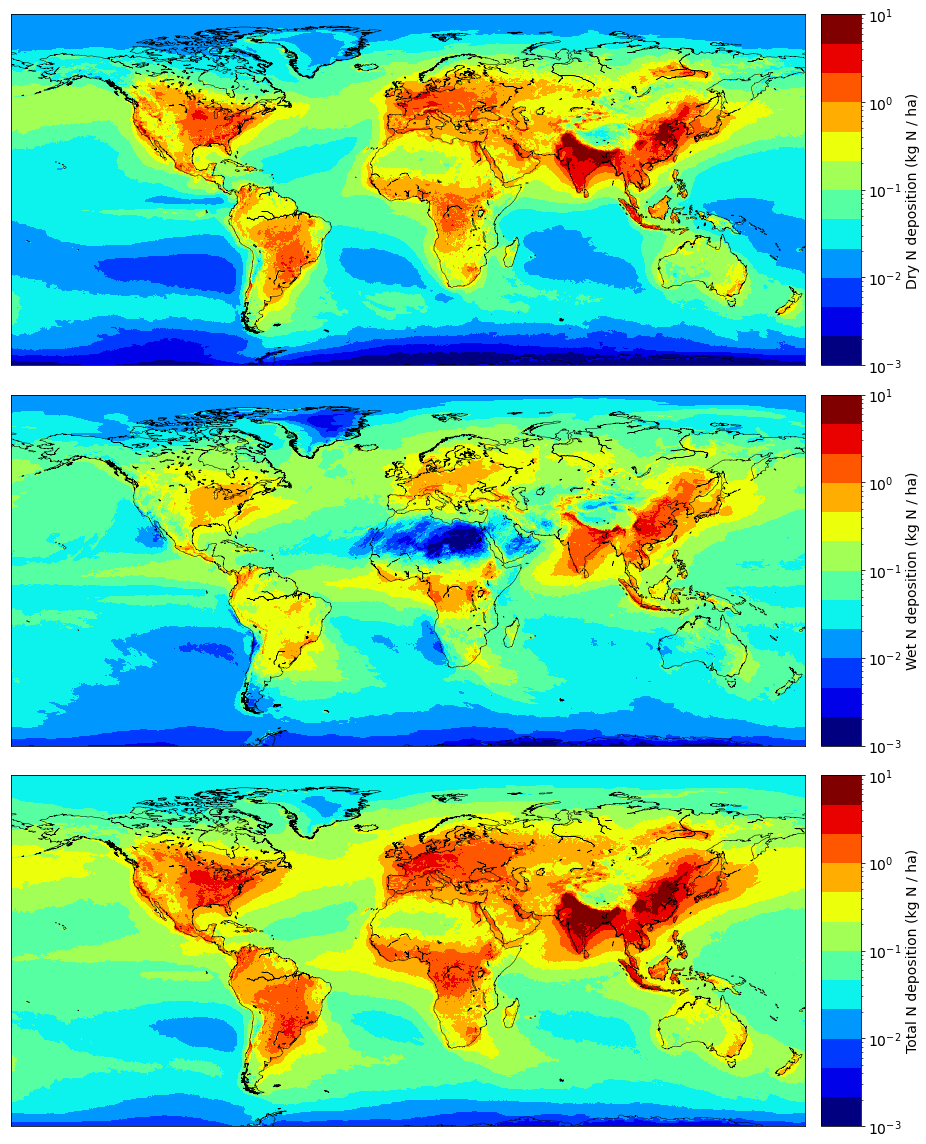

In [7]:
# Set up figure
plt.figure(figsize=(14,16))

# Multiple axes (top, middle, and bottom panels)
ax1 = plt.subplot(3,1,1)
ax2 = plt.subplot(3,1,2)
ax3 = plt.subplot(3,1,3)


# Top panel: Dry N deposition
# Set up basemap 
m = Basemap(projection='cyl',
            llcrnrlat=-70,urcrnrlat=89,
            llcrnrlon=-180,urcrnrlon=180, 
            resolution='l', ax=ax1)
m.drawcoastlines(linewidth=0.5)

# Select colormap properties
cmap = cm.get_cmap('jet', 12)

# Add data, colorbar, and labels.
p = m.pcolormesh(lon, lat, Total_Dry, shading='auto', cmap=cmap, norm=colors.LogNorm(vmin=0.001, vmax=10))
cbar = m.colorbar(p)
cbar.set_label(label='Dry N deposition (kg N / ha)', size=14)
cbar.ax.tick_params(labelsize=14)

# Middle panel: Wet N deposition
# Set up basemap 
m = Basemap(projection='cyl',
            llcrnrlat=-70,urcrnrlat=89,
            llcrnrlon=-180,urcrnrlon=180, 
            resolution='l', ax=ax2)
m.drawcoastlines(linewidth=0.5)

# Select colormap properties
#cmap = cm.get_cmap('Spectral_r', 30)

# Add data, colorbar, and labels.
p = m.pcolormesh(lon, lat, Total_Wet, shading='auto', cmap=cmap, norm=colors.LogNorm(vmin=0.001, vmax=10))
cbar = m.colorbar(p)
cbar.set_label(label='Wet N deposition (kg N / ha)', size=14)
cbar.ax.tick_params(labelsize=14)

# Bottom panel: Total N deposition
# Set up basemap 
m = Basemap(projection='cyl',
            llcrnrlat=-70,urcrnrlat=89,
            llcrnrlon=-180,urcrnrlon=180, 
            resolution='l', ax=ax3)
m.drawcoastlines(linewidth=0.5)

# Select colormap properties
#cmap = cm.get_cmap('Spectral_r', 30)

# Add data, colorbar, and labels.
p = m.pcolormesh(lon, lat, Total_Dry + Total_Wet, shading='auto', cmap=cmap, norm=colors.LogNorm(vmin=0.001, vmax=10))
cbar = m.colorbar(p)
cbar.set_label(label='Total N deposition (kg N / ha)', size=14)
cbar.ax.tick_params(labelsize=14)

# Configure and save final figure.
plt.tight_layout()
plt.savefig('N_Deposition_GEOS_CF_Prelim.png', dpi=600)